## 模型融合

Produced by 梅子行

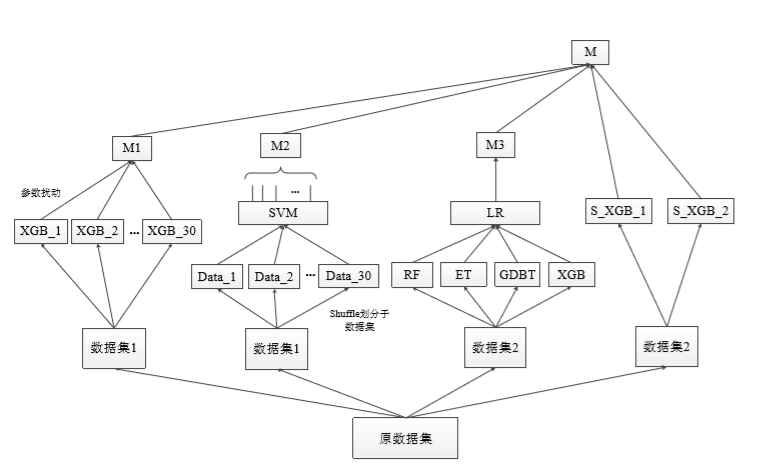

In [15]:
from IPython.display import Image
Image(filename='./image/2.png', width=700) 

### 投票器模型融合

In [4]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import pandas
import warnings
warnings.filterwarnings('ignore')

In [14]:
data = "pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']#class是类别标签
df = pandas.read_csv(data, names=names)
df.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df['class'].unique()

array([1, 0], dtype=int64)

In [9]:
array = df.values
X = array[:,0:8]
Y = array[:,8]
kfold = model_selection.KFold(n_splits=5, random_state=2018)

# 创建投票器的子模型
estimators = []
model_1 = LogisticRegression()
estimators.append(('logistic', model_1))

model_2 = DecisionTreeClassifier()
estimators.append(('dt', model_2))

model_3 = SVC()
estimators.append(('svm', model_3))

# 构建投票器融合
ensemble = VotingClassifier(estimators)
result = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(result.mean())

0.7410067057125881


### Bagging

In [11]:
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier()
num = 100
kfold = model_selection.KFold(n_splits=5, random_state=2018)
model = BaggingClassifier(base_estimator=dt, n_estimators=num, random_state=2018)
result = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(result.mean())

0.764349376114082


### RandomForest

In [12]:
from sklearn.ensemble import RandomForestClassifier
num_trees = 100
max_feature_num = 5
kfold = model_selection.KFold(n_splits=5, random_state=2018)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_feature_num)
result = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(result.mean())

0.7696120872591461


### Adaboost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
num_trees = 25
kfold = model_selection.KFold(n_splits=5, random_state=2018)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=2018)
result = model_selection.cross_val_score(model, X, Y, cv=kfold)
print(result.mean())

0.7513623631270689


通常我们有两种简单加权平均的方法，一种是预测结果直接加权平均，一种是按秩加权平均。  

- 预测结果直接加权平均时，需要注意的是如果不同模型预测的结果分布不太一致，如 A 模型预测结果区间一般是 [0, 0.4]，而 B 模型的大多在 [0.6, 1]，则需要先对 A、B 的预测结果做概率较正（probability calibration）。  
  
- 按秩加权是指将预测结果在预测样本集合中的序，加权平均。它的好处是不需要概率较正，但不能直接应用于线上实时预估场景中。  

当然，模型融合（Stacking／Ensembling）有更 fancy 的用法，比如和交叉验证结合，训练多层的融合模型。  

### Blending&Stacking

#### Stacking

stacking是一种分层模型集成框架。以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为特征加入训练集进行再训练，从而得到完整的stacking模型。

以5折划分为例，我们将原始训练集分为5折，分别记为fold1、fold2、fold3、fold4和fold5。此时我们使用fold2-fold5的数据来训练基模型1，并对fold1进行预测，该预测值即作为基模型1对fold1生成的元特征；同样地，使用fold1、fold3-fold5的数据来训练基模型1，并对fold2进行预测，该预测值即作为基模型1对fold2生成的元特征；以此类推，得到基模型1对整个原始训练集生成的元特征。同样地，对其他基模型也采用相同的方法生成元特征，从而构成用于第二层模型（下记为元模型，meta model）训练的完整元特征集。对于测试集，我们可以在每次基模型训练好时预测，再将预测值做均值处理；也可以将基模型拟合全部的训练集之后再对测试集进行预测。 

需要注意的是，在生成第二层特征的时候，各个基模型要采用相同的Kfold，这样得到的元特征的每一折（对应于之前的K折划分）都将不会泄露进该折数据的目标值信息 ，从而尽可能的降低过拟合的风险。虽然如此，实际上我们得到的元特征还是存在一定程度上的信息泄露，比如我们在预测第二折的时候，是利用了第一折的目标值信息用于训练基模型的，也就是说第一折的目标值信息杂糅在对第二折进行预测的基模型里。但是，实践中，这种程度的信息泄露所造成的过拟合程度很小。

#### Blending

Blending与Stacking大致相同，只是Blending的主要区别在于训练集不是通过K-Fold的CV策略来获得预测值从而生成第二阶段模型的特征，而是建立一个Holdout集，例如10%的训练数据，第二阶段的stacker模型就基于第一阶段模型对这10%训练数据的预测值进行拟合。说白了，就是把Stacking流程中的K-Fold CV 改成 HoldOut CV。

1）比赛常用，基本上排名靠前的选手都会使用模型融合的方法，通常在千分位上有所提升；  
2）实际工作中极少数场景可以使用，看似高级，实际业务中千分位的提升可有可无，部署30个模型费时费力，一旦出了问题查到死......

我们比赛时一般会使用一些特殊的方法进行多模型融合提高线上表现。在实际工作中可能用处不太广泛。  

感兴趣的同学可以看一下这篇code [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

思考一下我们常用的逻辑回归模型，在我们这个场景有什么优势？

### LR+离散特征优势

在工业界，很少直接将连续值作为特征喂给逻辑回归模型，而是将连续特征离散化为一系列0、1特征交给逻辑回归模型，这样做的优势有以下几点：  

1）稀疏向量内积乘法运算速度快，计算结果方便存储，容易scalable（扩展）。

2）离散化后的特征对异常数据有很强的鲁棒性：比如一个特征是年龄>30是1，否则0。如果特征没有离散化，一个异常数据“年龄300岁”会给模型造成很大的干扰。  

3）逻辑回归属于广义线性模型，表达能力受限；单变量离散化为N个后，每个变量有单独的权重，相当于为模型引入了非线性，能够提升模型表达能力，加大拟合。  

4）离散化后可以进行特征交叉，由M+N个变量变为$M*N$个变量，进一步引入非线性，提升表达能力。  

5）特征离散化后，模型会更稳定，比如如果对用户年龄离散化，20-30作为一个区间，不会因为一个用户年龄长了一岁就变成一个完全不同的人。当然处于区间相邻处的样本会刚好相反，所以怎么划分区间是门学问。  

6）离散后每一个特征的每一个取值对应着评分卡加减分数，业务上更容易理解。

#### 归纳一下就是：

#### 1）计算简单

#### 2）简化模型

#### 3）增强模型的泛化能力，不易受噪声的影响

#### 4）业务性强

#### 海量离散特征＋LR是业内常见的一个做法。而少量连续特征+复杂模型是另外一种做法，例如GBDT。

#### 模型是使用离散特征还是连续特征，其实是一个“海量离散特征+简单模型” 同 “少量连续特征+复杂模型”的权衡。既可以离散化用线性模型，也可以用连续特征加深度学习。  

### 人工特征 VS 机器特征

首先，海量离散特征＋LR是业内常见的一个做法，但并不是Holy Grail，事实上这一般而言仅仅是因为LR的优化算法更加成熟，而且可以在计算中利用稀疏特性进行更好的优化—可谓不得已而为之。

事实证明GBDT和深度学习特征的加入对于CTR预测是有正面帮助的。如果这个问题思考地更深一点，其实当前深度学习网络的最后一层，如果是binary classification，其实等同于LR。  

所以说，通过人工／半人工的方式产生的features，跟深度神经网络（无论之前用了怎样的结构）最后学出来的representation，其实是异曲同工，区别在于深度学习一般而言会学出一个dense representation，而特征工程做出来的是一堆sparse representation。  

某些时候，人工特征其实跟神经网络经过几层非线性之后的结果是高度相似的。  

在暴力提取高阶／非线性特征的本事上，机器肯定胜过人类。但是，就算最牛的机器智能，有时候都敌不过一些“人类常识”。尤其是业务的一些逻辑，可以认为是人脑在更大的一个数据集上pre-train出来的一些特征，其包含的信息量一定是大于你用于预测的dataset的。在这种情况下，往往厉害的人工features会outperform暴力的机器方法。  

所以，特征离散化，从数学角度来说可以认为是增加robustness，但是更重要的，make sense of the data，将数据转变成人类可以理解、可以validate的格式。人类的业务逻辑，当然也不是完美的。在当前机器智能还未征服“常识”这个领域之前，人类的business insights还是一个有力的补充（在很多case，甚至是最重要的部分）。在机器能够完全掌握的范围内，譬如围棋，人类引以为傲的intuition已经无法抵抗机器的暴力计算了——所以在未来，我们一定会看到越来越多的机器智能开始侵入一些传统上认为必须要依靠人类的“感觉”的一些领域。风控领域当然也不能躲过这个大的趋势。

### LR 适用于稀疏特征原因

假设有1w 个样本， y类别0和1，100维特征，其中10个样本都是类别1，而特征 f1的值为0，1，且刚好这10个样本的 f1特征值都为1，其余9990样本都为0(在高维稀疏的情况下这种情况很常见)，我们都知道这种情况在树模型的时候，很容易优化出含一个使用 f1为分裂节点的树直接将数据划分的很好，但是当测试的时候，却会发现效果很差，因为这个特征只是刚好偶然间跟 y拟合到了这个规律，这也是我们常说的过拟合。但是为什么线性模型就能对这种 case 处理的好？照理说线性模型在优化之后不也会产生这样一个式子嘛：

$$ y=W_1 * f_1+⋯+W_i∗f_i+⋯  $$ 

其中 $W_1$特别大以拟合这十个样本。因为反正$f_1$的值只有0和1，$W_1$过大对其他9990样本不会有任何影响。  

原因是因为现在的模型普遍都会带着正则项，而 lr 等线性模型的正则项是对权重的惩罚，也就是$W_1$一旦过大，惩罚就会很大，进一步压缩$W_1$的值，使他不至于过大。  

而树模型则不一样，树模型的惩罚项通常为叶子节点数和深度等，而我们都知道，对于上面这种 case，树只需要一个节点就可以完美分割9990和10个样本，惩罚项极其之小。

### LightGBM + LR 模型融合方案

大家都知道，在风控领域发展过程中，使用最多的方法就是逻辑回归(LR)，LR使用了Sigmoid变换将函数值映射到0~1区间，映射后的函数值就是一个人会违约的概率的预估值。   

LR属于线性模型，容易并行化，可以轻松处理上亿条数据，但是学习能力十分有限，需要大量的特征工程来增加模型的学习能力。将连续特征离散化，并对离散化的特征进行One-Hot编码，最后对特征进行二阶或者三阶的特征组合，目的是为了得到非线性的特征。但又无法直接通过特征笛卡尔积解决，只能依靠人工经验，耗时耗力同时并不一定会带来效果提升。特征工程存在几个难题：

* 连续变量切分点如何选取？
* 离散化为多少份合理？
* 选择哪些特征交叉？
* 多少阶交叉，二阶，三阶或更多？  

一般都是按照经验，不断尝试一些组合，然后根据线下评估选适当参数。  

但是，使用GBDT编码，一举解决了上面的问题。确定切分点不在是凭主观经验，而是根据信息增益，客观的选取切分点和份数。每棵决策树从根节点到叶节点的路径，会经过不同的特征，此路径就是特征组合，而且包含了二阶，三阶甚至更多。

#### 为什么不直接用GDBT？  

而非要用GDBT+LR呢？因为GDBT在线预测比较困难，而且训练时间复杂度高于LR。所以实际中，可以离线训练GDBT，然后将该模型作为在线ETL的一部分。

#### 在介绍这个模型之前，我们先来介绍两个问题：  

#### 1）为什么建树采用ensemble决策树，而不是单棵的决策树模型：

* 一棵树的表达能力很弱，不足以表达多个有区分性的特征组合。
* 多棵树的表达能力更强一些。可以更好的发现有效的特征和特征组合

#### 2）为什么建树采用GBDT而非RF：

* RF也是多棵树，但从效果上有实践证明不如GBDT。
* 且GBDT前面的树，特征分裂主要体现对多数样本有区分度的特征。
* 后面的树，主要体现的是经过前N颗树，残差仍然较大的少数样本。
* 优先选用在整体上有区分度的特征，再选用针对少数样本有区分度的特征，思路更加合理，这应该也是用GBDT的原因。

#### 下面看一下二者是如何融合的。

GBDT用来对训练集提取特征作为新的训练输入数据，LR作为新训练输入数据的分类器。  

具体步骤：

1）GBDT首先对原始训练数据做训练，得到一个二分类器，当然这里也需要利用网格搜索寻找最佳参数组合。  

2）与通常做法不同的是，当GBDT训练好做预测的时候，输出的并不是最终的二分类概率值，而是要把模型中的每棵树计算得到的预测概率值所属的叶子结点位置记为1，这样，就构造出了新的训练数据。在用GBDT构造新的训练数据时，采用的正是One-hot方法。并且由于每一弱分类器有且只有一个叶子节点输出预测结果，所以在一个具有n个弱分类器、共计m个叶子结点的GBDT中，每一条训练数据都会被转换为 1 * m 维稀疏向量，且有n个元素为1，其余m-n 个元素全为0。  

3）新的训练数据构造完成后，下一步就要与原始的训练数据中的label(输出)数据一并输入到Logistic Regression分类器中进行最终分类器的训练。思考一下，在对原始数据进行GBDT提取为新的数据这一操作之后，数据不仅变得稀疏，而且由于弱分类器个数，叶子结点个数的影响，可能会导致新的训练数据特征维度过大的问题，因此，在Logistic Regression这一层中，可使用正则化来减少过拟合的风险，在Facebook的论文中采用的是L1正则化。  

GBDT与LR的融合方式，Facebook的paper有个例子如下图所示。  

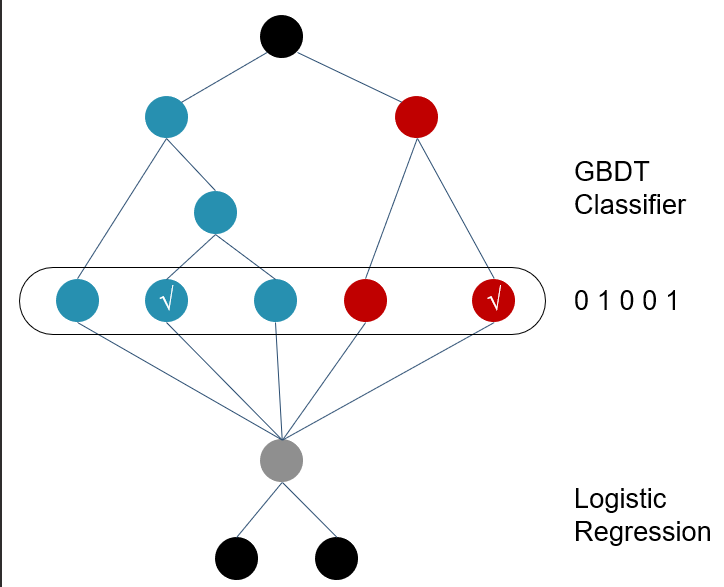

In [16]:
from IPython.display import Image
Image(filename='./image/1.png', width=500) 

图中Tree1、Tree2为通过GBDT模型学出来的两颗树，x为一条输入样本，遍历两棵树后，x样本分别落到两颗树的叶子节点上，每个叶子节点对应LR一维特征，那么通过遍历树，就得到了该样本对应的所有LR特征。由于树的每条路径，是通过最小化均方差等方法最终分割出来的有区分性路径，根据该路径得到的特征、特征组合都相对有区分性，效果理论上不会亚于人工经验的处理方式。

**论文中GBDT的参数，树的数量最多500颗（500以上就没有提升了），每棵树的节点不多于12。**  

通过GBDT生成的特征，可直接作为LR的特征使用，省去人工处理分析特征的环节。同时，也可考虑将GBDT生成特征与LR原有特征结合起来使用。

GBDT模型的特点，非常适合用来挖掘有效的特征、特征组合。业界不仅GBDT+LR融合有实践，GBDT+FM也有实践，2014 Kaggle CTR竞赛冠军就是使用GBDT+FM（因子分解机）。主要是因为CTR领域有大量的稀疏特征，LR学习效果没有FM好，但本节课只介绍XGBOOST+LR的方法，感兴趣的同学可以自己去做尝试。

In [129]:
import lightgbm as lgb
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import math
data = pd.read_csv('./data/Acard.txt')
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [130]:
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

train_ks :  0.4482453222991063
val_ks :  0.4198642457760936


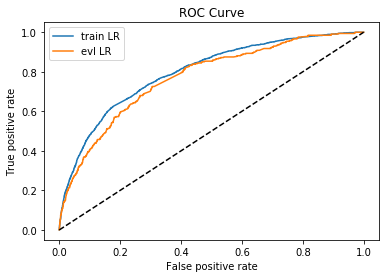

In [131]:
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()

feature_lst = ['person_info','finance_info','credit_info','act_info']

x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

lr_model = LogisticRegression(C=0.1,class_weight='balanced',solver='liblinear')
lr_model.fit(x,y)
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [132]:
df_train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
df_test = data[data.obs_mth == '2018-11-30'].reset_index().copy()
NUMERIC_COLS = ['person_info','finance_info','credit_info','act_info']

通过集成模型进行离散后究竟是升维还是降维全由树的个数来决定，num_boost_round 设置为50则变量转换后新的变量有50个维度，分别为在那一颗树上的第几个叶子节点上。叶子数量决定了每一个变量有多少取值，当然一层决策树即使设置100个叶子节点变量取值也只有{0,1}。

In [134]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

lgb_train = lgb.Dataset(df_train[NUMERIC_COLS], df_train['bad_ind'], free_raw_data=False)
params = {
    'num_boost_round': 50,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 2,
    'metric': 'auc',
    'max_depth':1,
    'feature_fraction':1,
    'bagging_fraction':1,
}
model = lgb.train(params,lgb_train)
leaf = model.predict(df_train[NUMERIC_COLS],pred_leaf=True)
lgb_enc = OneHotEncoder()
lgb_enc.fit(leaf)
data_leaf = np.hstack((lgb_enc.transform(leaf).toarray(),df_train[NUMERIC_COLS]))

C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


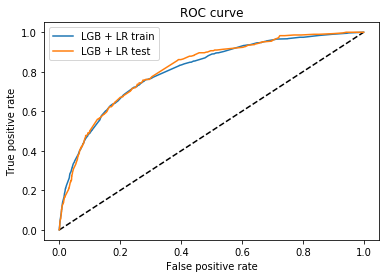

LGB+LR train ks: 0.4768266998563515 LGB+LR AUC: 0.8089506271108136
LGB+LR test ks: 0.482941737060417 LGB+LR AUC: 0.8150497181380825


In [135]:
train, val, train_y, val_y = train_test_split(data_leaf,df_train['bad_ind'],test_size=0.2, random_state=random.choice(range(10000)))

lgb_lm = LogisticRegression(penalty='l1',C = 0.3,solver='liblinear')
lgb_lm.fit(train, train_y)

y_pred_lgb_lm_train = lgb_lm.predict_proba(train)[:, 1]
fpr_lgb_lm_train, tpr_lgb_lm_train, _ = roc_curve(train_y, y_pred_lgb_lm_train)

y_pred_lgb_lm = lgb_lm.predict_proba(val)[:, 1]
fpr_lgb_lm, tpr_lgb_lm, _ = roc_curve(val_y, y_pred_lgb_lm)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgb_lm_train, tpr_lgb_lm_train, label='LGB + LR train')
plt.plot(fpr_lgb_lm, tpr_lgb_lm, label='LGB + LR test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('LGB+LR train ks:',abs(fpr_lgb_lm_train - tpr_lgb_lm_train).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm_train, tpr_lgb_lm_train))
print('LGB+LR test ks:',abs(fpr_lgb_lm - tpr_lgb_lm).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm, tpr_lgb_lm))

In [136]:
leaf_test = model.predict(df_test[NUMERIC_COLS],pred_leaf=True)
lgb_enc = OneHotEncoder()
lgb_enc.fit(leaf_test)
data_leaf_test = np.hstack((lgb_enc.transform(leaf_test).toarray(),df_test[NUMERIC_COLS]))

C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


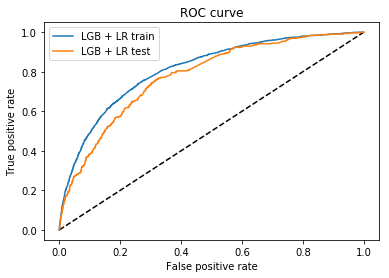

LGB+LR train ks: 0.4812287054151174 LGB+LR AUC: 0.8116324829085549
LGB+LR test ks: 0.4441149787927866 LGB+LR AUC: 0.777624032191942


In [137]:
train = data_leaf.copy()
train_y = df_train['bad_ind'].copy()
val = data_leaf_test.copy()
val_y = df_test['bad_ind'].copy()

lgb_lm = LogisticRegression(penalty='l2',C = 0.2,class_weight='balanced',solver='liblinear')
lgb_lm.fit(train, train_y)

y_pred_lgb_lm_train = lgb_lm.predict_proba(train)[:, 1]
fpr_lgb_lm_train, tpr_lgb_lm_train, _ = roc_curve(train_y, y_pred_lgb_lm_train)

y_pred_lgb_lm = lgb_lm.predict_proba(val)[:, 1]
fpr_lgb_lm, tpr_lgb_lm, _ = roc_curve(val_y, y_pred_lgb_lm)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgb_lm_train, tpr_lgb_lm_train, label='LGB + LR train')
plt.plot(fpr_lgb_lm, tpr_lgb_lm, label='LGB + LR test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('LGB+LR train ks:',abs(fpr_lgb_lm_train - tpr_lgb_lm_train).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm_train, tpr_lgb_lm_train))
print('LGB+LR test ks:',abs(fpr_lgb_lm - tpr_lgb_lm).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm, tpr_lgb_lm))

变量维度应该是树的个数，50维变量可能稍显多了一点，我们再做一次特征筛选

In [138]:
dff_train = pd.DataFrame(train)
dff_train.columns = [ 'ft' + str(x) for x in range(train.shape[1])]

dff_val = pd.DataFrame(val)
dff_val.columns = [ 'ft' + str(x) for x in range(val.shape[1])]

In [139]:
#生成可以传入PSI的数据集
def make_psi_data(dff_train):
    dftot = pd.DataFrame()
    for col in dff_train.columns:
        zero= sum(dff_train[col] == 0)
        one= sum(dff_train[col] == 1)
        ftdf = pd.DataFrame(np.array([zero,one]))
        ftdf.columns = [col]
        if len(dftot) == 0:
            dftot = ftdf.copy()
        else:
            dftot[col] = ftdf[col].copy()
    return dftot
psi_data_train = make_psi_data(dff_train)
psi_data_val = make_psi_data(dff_val)

In [140]:
#定义根据psi_data计算psi的函数
def var_PSI(dev_data, val_data):
    dev_cnt, val_cnt = sum(dev_data), sum(val_data)
    if dev_cnt * val_cnt == 0:
        return 0
    PSI = 0
    for i in range(len(dev_data)):
        dev_ratio = dev_data[i] / dev_cnt
        val_ratio = val_data[i] / val_cnt + 1e-10
        psi = (dev_ratio - val_ratio) * math.log(dev_ratio/val_ratio)
        PSI += psi
    return PSI
psi_dct = {}
for col in dff_train.columns:
    psi_dct[col] = var_PSI(psi_data_train[col],psi_data_val[col])

In [141]:
#这里去掉PSI排名在后40%的变量
f = zip(psi_dct.keys(),psi_dct.values())
f = sorted(f,key = lambda x:x[1],reverse = False)
psi_df = pd.DataFrame(f)
psi_df.columns = pd.Series(['变量名','PSI'])
feature_lst = list(psi_df[psi_df['PSI']<psi_df.quantile(0.6)[0]]['变量名'])

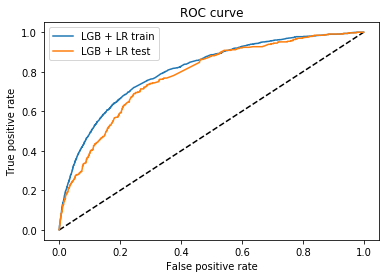

LGB+LR train ks: 0.47632382032329534 LGB+LR AUC: 0.8072776250020943
LGB+LR test ks: 0.4463346827179526 LGB+LR AUC: 0.7794117589750704


In [146]:
train = dff_train[feature_lst].copy()
train_y = df_train['bad_ind'].copy()
val = dff_val[feature_lst].copy()
val_y = df_test['bad_ind'].copy()

lgb_lm = LogisticRegression(C = 0.3,class_weight='balanced',solver='liblinear')
lgb_lm.fit(train, train_y)

y_pred_lgb_lm_train = lgb_lm.predict_proba(train)[:, 1]
fpr_lgb_lm_train, tpr_lgb_lm_train, _ = roc_curve(train_y, y_pred_lgb_lm_train)

y_pred_lgb_lm = lgb_lm.predict_proba(val)[:, 1]
fpr_lgb_lm, tpr_lgb_lm, _ = roc_curve(val_y, y_pred_lgb_lm)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgb_lm_train, tpr_lgb_lm_train, label='LGB + LR train')
plt.plot(fpr_lgb_lm, tpr_lgb_lm, label='LGB + LR test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('LGB+LR train ks:',abs(fpr_lgb_lm_train - tpr_lgb_lm_train).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm_train, tpr_lgb_lm_train))
print('LGB+LR test ks:',abs(fpr_lgb_lm - tpr_lgb_lm).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm, tpr_lgb_lm))

In [147]:
#通过特征重要性筛选特征

x = train
y = train_y

val_x =  val
val_y = val_y

#定义lgb函数
def LGB_test(train_x,train_y,test_x,test_y):
    from multiprocessing import cpu_count
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
        max_depth=2, n_estimators=800,max_features = 140, objective='binary',
        subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
        learning_rate=0.05, min_child_weight=50,random_state=None,n_jobs=cpu_count()-1,
    )
    clf.fit(train_x, train_y,eval_set=[(train_x, train_y),(test_x,test_y)],eval_metric='auc',early_stopping_rounds=100)

    return clf,clf.best_score_[ 'valid_1']['auc']

model,auc = LGB_test(x,y,val_x,val_y)                    

#模型贡献度放在feture中
feature = pd.DataFrame(
            {'name' : model.booster_.feature_name(),
            'importance' : model.feature_importances_
          }).sort_values(by =  ['importance'],ascending = False)

[1]	training's auc: 0.735977	training's binary_logloss: 0.0904249	valid_1's auc: 0.717857	valid_1's binary_logloss: 0.0988264
Training until validation scores don't improve for 100 rounds.
[2]	training's auc: 0.751043	training's binary_logloss: 0.0892454	valid_1's auc: 0.737785	valid_1's binary_logloss: 0.0976463
[3]	training's auc: 0.767286	training's binary_logloss: 0.0881609	valid_1's auc: 0.747415	valid_1's binary_logloss: 0.0965036
[4]	training's auc: 0.766443	training's binary_logloss: 0.0873288	valid_1's auc: 0.7493	valid_1's binary_logloss: 0.095535
[5]	training's auc: 0.767264	training's binary_logloss: 0.0865411	valid_1's auc: 0.751433	valid_1's binary_logloss: 0.0947231
[6]	training's auc: 0.769042	training's binary_logloss: 0.0859196	valid_1's auc: 0.749516	valid_1's binary_logloss: 0.0941632
[7]	training's auc: 0.791337	training's binary_logloss: 0.0853797	valid_1's auc: 0.760376	valid_1's binary_logloss: 0.0937817
[8]	training's auc: 0.792042	training's binary_logloss: 0.

[74]	training's auc: 0.813528	training's binary_logloss: 0.0784756	valid_1's auc: 0.780475	valid_1's binary_logloss: 0.0896156
[75]	training's auc: 0.813512	training's binary_logloss: 0.0784656	valid_1's auc: 0.780811	valid_1's binary_logloss: 0.0896133
[76]	training's auc: 0.81354	training's binary_logloss: 0.0784484	valid_1's auc: 0.78088	valid_1's binary_logloss: 0.0895872
[77]	training's auc: 0.813586	training's binary_logloss: 0.0784303	valid_1's auc: 0.780874	valid_1's binary_logloss: 0.0895854
[78]	training's auc: 0.813617	training's binary_logloss: 0.0784206	valid_1's auc: 0.780828	valid_1's binary_logloss: 0.0895958
[79]	training's auc: 0.813788	training's binary_logloss: 0.0783989	valid_1's auc: 0.780593	valid_1's binary_logloss: 0.0896198
[80]	training's auc: 0.813867	training's binary_logloss: 0.0783873	valid_1's auc: 0.780626	valid_1's binary_logloss: 0.0896232
[81]	training's auc: 0.813903	training's binary_logloss: 0.0783795	valid_1's auc: 0.780649	valid_1's binary_loglo

[154]	training's auc: 0.815878	training's binary_logloss: 0.0779161	valid_1's auc: 0.782466	valid_1's binary_logloss: 0.089449
[155]	training's auc: 0.815886	training's binary_logloss: 0.0779151	valid_1's auc: 0.782478	valid_1's binary_logloss: 0.0894488
[156]	training's auc: 0.8159	training's binary_logloss: 0.0779146	valid_1's auc: 0.782025	valid_1's binary_logloss: 0.0894399
[157]	training's auc: 0.815917	training's binary_logloss: 0.0779078	valid_1's auc: 0.782057	valid_1's binary_logloss: 0.0894483
[158]	training's auc: 0.815879	training's binary_logloss: 0.0779066	valid_1's auc: 0.78199	valid_1's binary_logloss: 0.0894433
[159]	training's auc: 0.815898	training's binary_logloss: 0.0779015	valid_1's auc: 0.782014	valid_1's binary_logloss: 0.0894353
[160]	training's auc: 0.815962	training's binary_logloss: 0.0778909	valid_1's auc: 0.782046	valid_1's binary_logloss: 0.0894326
[161]	training's auc: 0.815977	training's binary_logloss: 0.0778862	valid_1's auc: 0.782381	valid_1's binary

[230]	training's auc: 0.816726	training's binary_logloss: 0.0777132	valid_1's auc: 0.781858	valid_1's binary_logloss: 0.0894581
[231]	training's auc: 0.816731	training's binary_logloss: 0.0777086	valid_1's auc: 0.781929	valid_1's binary_logloss: 0.0894618
[232]	training's auc: 0.816788	training's binary_logloss: 0.0777062	valid_1's auc: 0.782025	valid_1's binary_logloss: 0.0894556
[233]	training's auc: 0.816843	training's binary_logloss: 0.0777058	valid_1's auc: 0.782068	valid_1's binary_logloss: 0.0894477
[234]	training's auc: 0.816831	training's binary_logloss: 0.0777019	valid_1's auc: 0.781934	valid_1's binary_logloss: 0.0894422
[235]	training's auc: 0.816814	training's binary_logloss: 0.0777002	valid_1's auc: 0.78186	valid_1's binary_logloss: 0.0894378
[236]	training's auc: 0.816843	training's binary_logloss: 0.0776974	valid_1's auc: 0.78193	valid_1's binary_logloss: 0.089428
[237]	training's auc: 0.816837	training's binary_logloss: 0.0776939	valid_1's auc: 0.781959	valid_1's binar

In [148]:
feature_lst2 = list(feature[feature.importance>5].name)

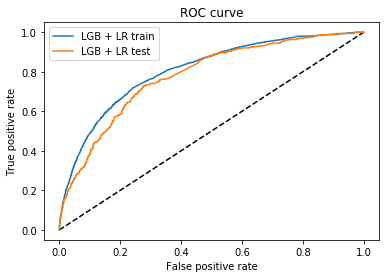

LGB+LR train ks: 0.47667824138882076 LGB+LR AUC: 0.8066539026120779
LGB+LR test ks: 0.45148080283448705 LGB+LR AUC: 0.7791867099903822


In [149]:
train = dff_train[feature_lst2].copy()
train_y = df_train['bad_ind'].copy()
val = dff_val[feature_lst2].copy()
val_y = df_test['bad_ind'].copy()

lgb_lm = LogisticRegression(C = 0.3,class_weight='balanced',solver='liblinear')
lgb_lm.fit(train, train_y)

y_pred_lgb_lm_train = lgb_lm.predict_proba(train)[:, 1]
fpr_lgb_lm_train, tpr_lgb_lm_train, _ = roc_curve(train_y, y_pred_lgb_lm_train)

y_pred_lgb_lm = lgb_lm.predict_proba(val)[:, 1]
fpr_lgb_lm, tpr_lgb_lm, _ = roc_curve(val_y, y_pred_lgb_lm)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgb_lm_train, tpr_lgb_lm_train, label='LGB + LR train')
plt.plot(fpr_lgb_lm, tpr_lgb_lm, label='LGB + LR test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('LGB+LR train ks:',abs(fpr_lgb_lm_train - tpr_lgb_lm_train).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm_train, tpr_lgb_lm_train))
print('LGB+LR test ks:',abs(fpr_lgb_lm - tpr_lgb_lm).max(),'LGB+LR AUC:', metrics.auc(fpr_lgb_lm, tpr_lgb_lm))

In [153]:
from pytorch import nn
class FM_model(nn.Module):
    def __init__(self, n, k):
        super(FM_model, self).__init__()
        self.n = n # len(items) + len(users)
        self.k = k
        self.linear = nn.Linear(self.n, 1, bias=True)
        self.v = nn.Parameter(torch.randn(self.k, self.n))

    def fm_layer(self, x):
      	# x 属于 R^{batch*n}
        linear_part = self.linear(x)
        # 矩阵相乘 (batch*p) * (p*k)
        inter_part1 = torch.mm(x, self.v.t())  # out_size = (batch, k)
        # 矩阵相乘 (batch*p)^2 * (p*k)^2
        inter_part2 = torch.mm(torch.pow(x, 2), torch.pow(self.v, 2).t()) # out_size = (batch, k) 
        output = linear_part + 0.5 * torch.sum(torch.pow(inter_part1, 2) - inter_part2) 
        # 这里torch求和一定要用sum
        return output  # out_size = (batch, 1)

    def forward(self, x):
        output = self.fm_layer(x)
        return output

ModuleNotFoundError: No module named 'pytorch'